# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import os
import requests
import time
from scipy.stats import linregress
from pprint import pprint
import logging
import datetime as dt
import pytz

logger = logging.Logger('catch_all')

# Import API key and build partial query URL for Open Weather Map API....
#api.openweathermap.org/data/2.5/weather?q={city name}&appid={your api key}
from api_keys import weather_api_key
wurl = "http://api.openweathermap.org/data/2.5/weather?"
query_url = f"{wurl}appid={weather_api_key}&units=imperial&q="

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/weather_data.csv"

# scatter plot outputs....
# plot_out_dir = os.path.join("../", "output_data/")
plot_out_dir = "../output_data/"

# preparing current date field to display in all charts
pdate = (dt.datetime.now()).strftime('%m/%d/%y')
sdate = '('+ pdate + ')'
sdate

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Define functions here....
# def tz_from_utc_ms_ts(utc_ms_ts, tz_info):
#     """Given millisecond utc timestamp and a timezone return dateime

#     :param utc_ms_ts: Unix UTC timestamp in milliseconds
#     :param tz_info: timezone info
#     :return: timezone aware datetime
#     """
#     # convert from time stamp to datetime
#     utc_datetime = dt.datetime.utcfromtimestamp(utc_ms_ts / 1000.)

#     # set the timezone to UTC, and then convert to desired timezone
#     return utc_datetime.replace(tzinfo=pytz.timezone('UTC')).astimezone(tz_info)


## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
total_cities = len(cities)
unique_cities = pd.Series(cities).drop_duplicates().tolist()
print(f"Total Cities : {total_cities}    Unique Cities : {len(unique_cities)}")

Total Cities : 599    Unique Cities : 599


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
weather_data_df = pd.DataFrame({"City":unique_cities,
                                "Cloudiness":"",
                                "Country":"",
                                "Date":"",
                                "Humidity":"",
                                "Lat":"",
                                "Lng":"",
                                "Max Temp":"",
                                "Wind Speed":""
                               })
weather_data_df

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,izyum,,,,,,,,
1,cabo san lucas,,,,,,,,
2,illoqqortoormiut,,,,,,,,
3,pisco,,,,,,,,
4,hasaki,,,,,,,,
...,...,...,...,...,...,...,...,...,...
594,bhawana,,,,,,,,
595,dourbali,,,,,,,,
596,vardo,,,,,,,,
597,mantua,,,,,,,,


In [4]:
batch_cnt = 1
rec_cnt = 0
err_cnt = 0
print(f"Begining Data Retrieval from Open Weather. Estimated time {round(total_cities/60,4)} minutes...")
print(" ")
start_time = time.time()
etime = start_time + 60

for index, row in weather_data_df.iterrows():
    resp = ""
    rec_cnt = rec_cnt + 1
    resp = requests.get(query_url + row['City']).json()
    try:
        print(f"Retrieving Results for the city: {row['City'].title()}. \
 (Index: {index} Batch: {batch_cnt} Count: {rec_cnt})")
        row['Lat'] = (resp['coord']['lat'])
        row['Lng'] = resp['coord']['lon']
        row['Cloudiness'] = resp['clouds']['all']
        row['Country'] = resp['sys']['country']
        row['Humidity'] = resp['main']['humidity']
        row['Max Temp'] = resp['main']['temp_max']
        row['Wind Speed'] = resp['wind']['speed']
        row['Date'] = resp['dt']

    except Exception as e:
        logger.error('Failed to retreive the results for the City : '+ row['City'] + ' Error : ' + str(e))
        err_cnt = err_cnt + 1

    if rec_cnt > 58:
        #       assuming it's going to take < 60 seconds to process 59 records...
        slp_sec = round(etime - time.time(),0)
        if slp_sec > 0:
            print(f"API Calls count reached: {rec_cnt} in {round(time.time()-(etime-60),6)} seconds...\
and going to sleep for {slp_sec} seconds!!!")
            time.sleep(slp_sec)

    if (time.time() - etime)  >= 0:
        etime = etime + 60
        batch_cnt = batch_cnt + 1
        rec_cnt = 0
        print(" ")
        print(f"Remaining seconds....{round(etime-time.time(),4)}   Batch : {batch_cnt} ")
        print(" ")

print(" ")
print(f"End of processing {index+1} records in {round((time.time()-start_time)/60,4)} minutes!!!   \
 (Estimated time {round(total_cities/60,4)} minutes...)")
print(" ")
print(f"Rows without data : {err_cnt}") 
print(f"Rows available for data analysis after deletion : {(index+1)-err_cnt}")
print(" ")

Begining Data Retrieval from Open Weather. Estimated time 9.9833 minutes...
 
Retrieving Results for the city: Izyum.  (Index: 0 Batch: 1 Count: 1)
Retrieving Results for the city: Cabo San Lucas.  (Index: 1 Batch: 1 Count: 2)


Failed to retreive the results for the City : illoqqortoormiut Error : 'coord'


Retrieving Results for the city: Illoqqortoormiut.  (Index: 2 Batch: 1 Count: 3)
Retrieving Results for the city: Pisco.  (Index: 3 Batch: 1 Count: 4)


Failed to retreive the results for the City : mys shmidta Error : 'coord'


Retrieving Results for the city: Hasaki.  (Index: 4 Batch: 1 Count: 5)
Retrieving Results for the city: Mys Shmidta.  (Index: 5 Batch: 1 Count: 6)
Retrieving Results for the city: Najran.  (Index: 6 Batch: 1 Count: 7)
Retrieving Results for the city: Touros.  (Index: 7 Batch: 1 Count: 8)
Retrieving Results for the city: Belmonte.  (Index: 8 Batch: 1 Count: 9)
Retrieving Results for the city: Yanam.  (Index: 9 Batch: 1 Count: 10)
Retrieving Results for the city: Port Elizabeth.  (Index: 10 Batch: 1 Count: 11)
Retrieving Results for the city: Yellowknife.  (Index: 11 Batch: 1 Count: 12)
Retrieving Results for the city: New Norfolk.  (Index: 12 Batch: 1 Count: 13)


Failed to retreive the results for the City : umzimvubu Error : 'coord'


Retrieving Results for the city: Umzimvubu.  (Index: 13 Batch: 1 Count: 14)
Retrieving Results for the city: Lagoa.  (Index: 14 Batch: 1 Count: 15)
Retrieving Results for the city: Busselton.  (Index: 15 Batch: 1 Count: 16)
Retrieving Results for the city: Ugoofaaru.  (Index: 16 Batch: 1 Count: 17)
Retrieving Results for the city: Dikson.  (Index: 17 Batch: 1 Count: 18)
Retrieving Results for the city: Oparino.  (Index: 18 Batch: 1 Count: 19)
Retrieving Results for the city: Ushuaia.  (Index: 19 Batch: 1 Count: 20)
Retrieving Results for the city: Mizoch.  (Index: 20 Batch: 1 Count: 21)
Retrieving Results for the city: Provideniya.  (Index: 21 Batch: 1 Count: 22)
Retrieving Results for the city: Vaini.  (Index: 22 Batch: 1 Count: 23)


Failed to retreive the results for the City : yanan Error : 'coord'


Retrieving Results for the city: Avarua.  (Index: 23 Batch: 1 Count: 24)
Retrieving Results for the city: Yanan.  (Index: 24 Batch: 1 Count: 25)
Retrieving Results for the city: Ahipara.  (Index: 25 Batch: 1 Count: 26)
Retrieving Results for the city: Hilo.  (Index: 26 Batch: 1 Count: 27)
Retrieving Results for the city: Castro.  (Index: 27 Batch: 1 Count: 28)
Retrieving Results for the city: Mataura.  (Index: 28 Batch: 1 Count: 29)
Retrieving Results for the city: Nikolskoye.  (Index: 29 Batch: 1 Count: 30)
Retrieving Results for the city: Manaure.  (Index: 30 Batch: 1 Count: 31)
Retrieving Results for the city: Hermanus.  (Index: 31 Batch: 1 Count: 32)
Retrieving Results for the city: Cape Town.  (Index: 32 Batch: 1 Count: 33)
Retrieving Results for the city: Guerrero Negro.  (Index: 33 Batch: 1 Count: 34)
Retrieving Results for the city: Chuy.  (Index: 34 Batch: 1 Count: 35)
Retrieving Results for the city: Tuktoyaktuk.  (Index: 35 Batch: 1 Count: 36)
Retrieving Results for the city

Failed to retreive the results for the City : barentsburg Error : 'coord'


Retrieving Results for the city: Khatanga.  (Index: 38 Batch: 1 Count: 39)
Retrieving Results for the city: Barentsburg.  (Index: 39 Batch: 1 Count: 40)
Retrieving Results for the city: Rio Gallegos.  (Index: 40 Batch: 1 Count: 41)
Retrieving Results for the city: Ostrovnoy.  (Index: 41 Batch: 1 Count: 42)
Retrieving Results for the city: Stromness.  (Index: 42 Batch: 1 Count: 43)
Retrieving Results for the city: Hithadhoo.  (Index: 43 Batch: 1 Count: 44)
Retrieving Results for the city: Mar Del Plata.  (Index: 44 Batch: 1 Count: 45)
Retrieving Results for the city: Sabang.  (Index: 45 Batch: 1 Count: 46)
Retrieving Results for the city: Marzuq.  (Index: 46 Batch: 1 Count: 47)
Retrieving Results for the city: Butaritari.  (Index: 47 Batch: 1 Count: 48)
Retrieving Results for the city: Barrow.  (Index: 48 Batch: 1 Count: 49)
Retrieving Results for the city: Hobart.  (Index: 49 Batch: 1 Count: 50)
Retrieving Results for the city: Puerto Ayora.  (Index: 50 Batch: 1 Count: 51)


Failed to retreive the results for the City : taolanaro Error : 'coord'


Retrieving Results for the city: Cidreira.  (Index: 51 Batch: 1 Count: 52)
Retrieving Results for the city: Taolanaro.  (Index: 52 Batch: 1 Count: 53)
Retrieving Results for the city: Rikitea.  (Index: 53 Batch: 1 Count: 54)
Retrieving Results for the city: Vanimo.  (Index: 54 Batch: 1 Count: 55)
Retrieving Results for the city: Kloulklubed.  (Index: 55 Batch: 1 Count: 56)
Retrieving Results for the city: Adrar.  (Index: 56 Batch: 1 Count: 57)


Failed to retreive the results for the City : sayanskiy Error : 'coord'


Retrieving Results for the city: Luderitz.  (Index: 57 Batch: 1 Count: 58)
Retrieving Results for the city: Sayanskiy.  (Index: 58 Batch: 1 Count: 59)
API Calls count reached: 59 in 12.289198 seconds...and going to sleep for 48.0 seconds!!!
 
Remaining seconds....59.7065   Batch : 2 
 
Retrieving Results for the city: Atar.  (Index: 59 Batch: 2 Count: 1)
Retrieving Results for the city: Shahumyan.  (Index: 60 Batch: 2 Count: 2)
Retrieving Results for the city: Tasiilaq.  (Index: 61 Batch: 2 Count: 3)
Retrieving Results for the city: Podosinovets.  (Index: 62 Batch: 2 Count: 4)
Retrieving Results for the city: Tessalit.  (Index: 63 Batch: 2 Count: 5)
Retrieving Results for the city: Athabasca.  (Index: 64 Batch: 2 Count: 6)
Retrieving Results for the city: Balikpapan.  (Index: 65 Batch: 2 Count: 7)
Retrieving Results for the city: Santa Cruz.  (Index: 66 Batch: 2 Count: 8)
Retrieving Results for the city: Faanui.  (Index: 67 Batch: 2 Count: 9)
Retrieving Results for the city: Golden.  (

Failed to retreive the results for the City : rawannawi Error : 'coord'


Retrieving Results for the city: Rawannawi.  (Index: 71 Batch: 2 Count: 13)
Retrieving Results for the city: Gao.  (Index: 72 Batch: 2 Count: 14)
Retrieving Results for the city: Albany.  (Index: 73 Batch: 2 Count: 15)
Retrieving Results for the city: Saskylakh.  (Index: 74 Batch: 2 Count: 16)
Retrieving Results for the city: Bluff.  (Index: 75 Batch: 2 Count: 17)
Retrieving Results for the city: Erenhot.  (Index: 76 Batch: 2 Count: 18)
Retrieving Results for the city: Punta Arenas.  (Index: 77 Batch: 2 Count: 19)
Retrieving Results for the city: Kruisfontein.  (Index: 78 Batch: 2 Count: 20)
Retrieving Results for the city: Mlonggo.  (Index: 79 Batch: 2 Count: 21)
Retrieving Results for the city: Tobermory.  (Index: 80 Batch: 2 Count: 22)


Failed to retreive the results for the City : lolua Error : 'coord'


Retrieving Results for the city: Lolua.  (Index: 81 Batch: 2 Count: 23)
Retrieving Results for the city: Kapaa.  (Index: 82 Batch: 2 Count: 24)
Retrieving Results for the city: Svencionys.  (Index: 83 Batch: 2 Count: 25)
Retrieving Results for the city: Puerto Escondido.  (Index: 84 Batch: 2 Count: 26)
Retrieving Results for the city: Bredasdorp.  (Index: 85 Batch: 2 Count: 27)
Retrieving Results for the city: Sitka.  (Index: 86 Batch: 2 Count: 28)
Retrieving Results for the city: Hambantota.  (Index: 87 Batch: 2 Count: 29)
Retrieving Results for the city: Jamestown.  (Index: 88 Batch: 2 Count: 30)
Retrieving Results for the city: Rorvik.  (Index: 89 Batch: 2 Count: 31)
Retrieving Results for the city: Huarmey.  (Index: 90 Batch: 2 Count: 32)
Retrieving Results for the city: Callaguip.  (Index: 91 Batch: 2 Count: 33)
Retrieving Results for the city: Estelle.  (Index: 92 Batch: 2 Count: 34)
Retrieving Results for the city: Naze.  (Index: 93 Batch: 2 Count: 35)


Failed to retreive the results for the City : attawapiskat Error : 'coord'


Retrieving Results for the city: Atuona.  (Index: 94 Batch: 2 Count: 36)
Retrieving Results for the city: Attawapiskat.  (Index: 95 Batch: 2 Count: 37)
Retrieving Results for the city: Belaya Gora.  (Index: 96 Batch: 2 Count: 38)
Retrieving Results for the city: Qui Nhon.  (Index: 97 Batch: 2 Count: 39)
Retrieving Results for the city: Leshukonskoye.  (Index: 98 Batch: 2 Count: 40)
Retrieving Results for the city: Kudahuvadhoo.  (Index: 99 Batch: 2 Count: 41)
Retrieving Results for the city: Chaozhou.  (Index: 100 Batch: 2 Count: 42)
Retrieving Results for the city: Olafsvik.  (Index: 101 Batch: 2 Count: 43)
Retrieving Results for the city: Los Algarrobos.  (Index: 102 Batch: 2 Count: 44)
Retrieving Results for the city: Ponta Do Sol.  (Index: 103 Batch: 2 Count: 45)
Retrieving Results for the city: Abu Dhabi.  (Index: 104 Batch: 2 Count: 46)
Retrieving Results for the city: Pangnirtung.  (Index: 105 Batch: 2 Count: 47)
Retrieving Results for the city: Muddebihal.  (Index: 106 Batch: 2

Failed to retreive the results for the City : karauzyak Error : 'coord'


Retrieving Results for the city: Karauzyak.  (Index: 108 Batch: 2 Count: 50)
Retrieving Results for the city: Popondetta.  (Index: 109 Batch: 2 Count: 51)
Retrieving Results for the city: Jampur.  (Index: 110 Batch: 2 Count: 52)
Retrieving Results for the city: Kaitangata.  (Index: 111 Batch: 2 Count: 53)
Retrieving Results for the city: Sibu.  (Index: 112 Batch: 2 Count: 54)
Retrieving Results for the city: Mahebourg.  (Index: 113 Batch: 2 Count: 55)
Retrieving Results for the city: Loei.  (Index: 114 Batch: 2 Count: 56)
Retrieving Results for the city: Lebu.  (Index: 115 Batch: 2 Count: 57)
Retrieving Results for the city: Sola.  (Index: 116 Batch: 2 Count: 58)
Retrieving Results for the city: Torbay.  (Index: 117 Batch: 2 Count: 59)
API Calls count reached: 59 in 11.61639 seconds...and going to sleep for 48.0 seconds!!!
Retrieving Results for the city: Perth.  (Index: 118 Batch: 2 Count: 60)
 
Remaining seconds....59.9026   Batch : 3 
 
Retrieving Results for the city: Brae.  (Index

Failed to retreive the results for the City : belushya guba Error : 'coord'


Retrieving Results for the city: Belushya Guba.  (Index: 135 Batch: 3 Count: 17)
Retrieving Results for the city: East London.  (Index: 136 Batch: 3 Count: 18)
Retrieving Results for the city: Broome.  (Index: 137 Batch: 3 Count: 19)
Retrieving Results for the city: Carnarvon.  (Index: 138 Batch: 3 Count: 20)
Retrieving Results for the city: Maumere.  (Index: 139 Batch: 3 Count: 21)
Retrieving Results for the city: Ancud.  (Index: 140 Batch: 3 Count: 22)
Retrieving Results for the city: Runcu.  (Index: 141 Batch: 3 Count: 23)
Retrieving Results for the city: North Bend.  (Index: 142 Batch: 3 Count: 24)


Failed to retreive the results for the City : amderma Error : 'coord'


Retrieving Results for the city: Saint Anthony.  (Index: 143 Batch: 3 Count: 25)
Retrieving Results for the city: Amderma.  (Index: 144 Batch: 3 Count: 26)
Retrieving Results for the city: Tierralta.  (Index: 145 Batch: 3 Count: 27)
Retrieving Results for the city: Alakurtti.  (Index: 146 Batch: 3 Count: 28)


Failed to retreive the results for the City : saleaula Error : 'coord'


Retrieving Results for the city: Saleaula.  (Index: 147 Batch: 3 Count: 29)
Retrieving Results for the city: Chokurdakh.  (Index: 148 Batch: 3 Count: 30)
Retrieving Results for the city: Mapiripan.  (Index: 149 Batch: 3 Count: 31)
Retrieving Results for the city: Sioux Lookout.  (Index: 150 Batch: 3 Count: 32)
Retrieving Results for the city: Ulladulla.  (Index: 151 Batch: 3 Count: 33)
Retrieving Results for the city: Saint-Leu.  (Index: 152 Batch: 3 Count: 34)
Retrieving Results for the city: Nurota.  (Index: 153 Batch: 3 Count: 35)
Retrieving Results for the city: Nome.  (Index: 154 Batch: 3 Count: 36)
Retrieving Results for the city: Kalmunai.  (Index: 155 Batch: 3 Count: 37)
Retrieving Results for the city: Lompoc.  (Index: 156 Batch: 3 Count: 38)
Retrieving Results for the city: Bambous Virieux.  (Index: 157 Batch: 3 Count: 39)
Retrieving Results for the city: Abrau-Dyurso.  (Index: 158 Batch: 3 Count: 40)
Retrieving Results for the city: Khudumelapye.  (Index: 159 Batch: 3 Count:

Failed to retreive the results for the City : marcona Error : 'coord'


Retrieving Results for the city: Marcona.  (Index: 164 Batch: 3 Count: 46)
Retrieving Results for the city: Roald.  (Index: 165 Batch: 3 Count: 47)
Retrieving Results for the city: Bethel.  (Index: 166 Batch: 3 Count: 48)
Retrieving Results for the city: Richards Bay.  (Index: 167 Batch: 3 Count: 49)


Failed to retreive the results for the City : grand river south east Error : 'coord'


Retrieving Results for the city: Umtata.  (Index: 168 Batch: 3 Count: 50)
Retrieving Results for the city: Grand River South East.  (Index: 169 Batch: 3 Count: 51)


Failed to retreive the results for the City : eldikan Error : 'coord'


Retrieving Results for the city: Podporozhye.  (Index: 170 Batch: 3 Count: 52)
Retrieving Results for the city: Eldikan.  (Index: 171 Batch: 3 Count: 53)
Retrieving Results for the city: Felanitx.  (Index: 172 Batch: 3 Count: 54)
Retrieving Results for the city: Luanda.  (Index: 173 Batch: 3 Count: 55)


Failed to retreive the results for the City : vaitupu Error : 'coord'


Retrieving Results for the city: Iqaluit.  (Index: 174 Batch: 3 Count: 56)
Retrieving Results for the city: Vaitupu.  (Index: 175 Batch: 3 Count: 57)
Retrieving Results for the city: Ilulissat.  (Index: 176 Batch: 3 Count: 58)
Retrieving Results for the city: Nouadhibou.  (Index: 177 Batch: 3 Count: 59)
API Calls count reached: 59 in 11.418614 seconds...and going to sleep for 49.0 seconds!!!
 
Remaining seconds....59.5794   Batch : 4 
 
Retrieving Results for the city: Severo-Yeniseyskiy.  (Index: 178 Batch: 4 Count: 1)
Retrieving Results for the city: Kinablangan.  (Index: 179 Batch: 4 Count: 2)
Retrieving Results for the city: Fenoarivo.  (Index: 180 Batch: 4 Count: 3)
Retrieving Results for the city: Skelleftea.  (Index: 181 Batch: 4 Count: 4)
Retrieving Results for the city: Coari.  (Index: 182 Batch: 4 Count: 5)
Retrieving Results for the city: Veraval.  (Index: 183 Batch: 4 Count: 6)
Retrieving Results for the city: Aswan.  (Index: 184 Batch: 4 Count: 7)
Retrieving Results for th

Failed to retreive the results for the City : tsihombe Error : 'coord'


Retrieving Results for the city: Tsihombe.  (Index: 186 Batch: 4 Count: 9)
Retrieving Results for the city: Hirara.  (Index: 187 Batch: 4 Count: 10)
Retrieving Results for the city: Quatre Cocos.  (Index: 188 Batch: 4 Count: 11)
Retrieving Results for the city: Victoria.  (Index: 189 Batch: 4 Count: 12)
Retrieving Results for the city: Airai.  (Index: 190 Batch: 4 Count: 13)
Retrieving Results for the city: Montepuez.  (Index: 191 Batch: 4 Count: 14)
Retrieving Results for the city: Butembo.  (Index: 192 Batch: 4 Count: 15)
Retrieving Results for the city: Sturgis.  (Index: 193 Batch: 4 Count: 16)
Retrieving Results for the city: Kirakira.  (Index: 194 Batch: 4 Count: 17)
Retrieving Results for the city: Fujin.  (Index: 195 Batch: 4 Count: 18)
Retrieving Results for the city: Constitucion.  (Index: 196 Batch: 4 Count: 19)
Retrieving Results for the city: Sur.  (Index: 197 Batch: 4 Count: 20)
Retrieving Results for the city: Port-Gentil.  (Index: 198 Batch: 4 Count: 21)
Retrieving Resul

Failed to retreive the results for the City : kerteh Error : 'coord'


Retrieving Results for the city: Kerteh.  (Index: 213 Batch: 4 Count: 36)
Retrieving Results for the city: Saint-Philippe.  (Index: 214 Batch: 4 Count: 37)
Retrieving Results for the city: Camana.  (Index: 215 Batch: 4 Count: 38)
Retrieving Results for the city: Camacha.  (Index: 216 Batch: 4 Count: 39)
Retrieving Results for the city: Santa Fe.  (Index: 217 Batch: 4 Count: 40)
Retrieving Results for the city: Tuy Hoa.  (Index: 218 Batch: 4 Count: 41)
Retrieving Results for the city: Talara.  (Index: 219 Batch: 4 Count: 42)
Retrieving Results for the city: Port Moresby.  (Index: 220 Batch: 4 Count: 43)
Retrieving Results for the city: Mandera.  (Index: 221 Batch: 4 Count: 44)
Retrieving Results for the city: Nara.  (Index: 222 Batch: 4 Count: 45)
Retrieving Results for the city: Praia Da Vitoria.  (Index: 223 Batch: 4 Count: 46)
Retrieving Results for the city: Chumikan.  (Index: 224 Batch: 4 Count: 47)
Retrieving Results for the city: Asfi.  (Index: 225 Batch: 4 Count: 48)
Retrieving 

Failed to retreive the results for the City : palabuhanratu Error : 'coord'


Retrieving Results for the city: Palabuhanratu.  (Index: 257 Batch: 5 Count: 20)


Failed to retreive the results for the City : barawe Error : 'coord'


Retrieving Results for the city: Barawe.  (Index: 258 Batch: 5 Count: 21)
Retrieving Results for the city: Gulariya.  (Index: 259 Batch: 5 Count: 22)
Retrieving Results for the city: Sambava.  (Index: 260 Batch: 5 Count: 23)
Retrieving Results for the city: Eganville.  (Index: 261 Batch: 5 Count: 24)
Retrieving Results for the city: Okhotsk.  (Index: 262 Batch: 5 Count: 25)
Retrieving Results for the city: Kara-Tyube.  (Index: 263 Batch: 5 Count: 26)
Retrieving Results for the city: Berlevag.  (Index: 264 Batch: 5 Count: 27)
Retrieving Results for the city: Cockburn Town.  (Index: 265 Batch: 5 Count: 28)
Retrieving Results for the city: Krasnogorskoye.  (Index: 266 Batch: 5 Count: 29)
Retrieving Results for the city: Lasa.  (Index: 267 Batch: 5 Count: 30)


Failed to retreive the results for the City : samusu Error : 'coord'


Retrieving Results for the city: Samusu.  (Index: 268 Batch: 5 Count: 31)
Retrieving Results for the city: Russell.  (Index: 269 Batch: 5 Count: 32)
Retrieving Results for the city: Gamboma.  (Index: 270 Batch: 5 Count: 33)


Failed to retreive the results for the City : barroualie Error : 'coord'


Retrieving Results for the city: Catuday.  (Index: 271 Batch: 5 Count: 34)
Retrieving Results for the city: Barroualie.  (Index: 272 Batch: 5 Count: 35)


Failed to retreive the results for the City : dzhusaly Error : 'coord'


Retrieving Results for the city: Marawi.  (Index: 273 Batch: 5 Count: 36)
Retrieving Results for the city: Dzhusaly.  (Index: 274 Batch: 5 Count: 37)
Retrieving Results for the city: Port Hawkesbury.  (Index: 275 Batch: 5 Count: 38)
Retrieving Results for the city: Ryotsu.  (Index: 276 Batch: 5 Count: 39)
Retrieving Results for the city: Arraial Do Cabo.  (Index: 277 Batch: 5 Count: 40)
Retrieving Results for the city: Pevek.  (Index: 278 Batch: 5 Count: 41)
Retrieving Results for the city: Charyshskoye.  (Index: 279 Batch: 5 Count: 42)
Retrieving Results for the city: Salalah.  (Index: 280 Batch: 5 Count: 43)
Retrieving Results for the city: Matay.  (Index: 281 Batch: 5 Count: 44)


Failed to retreive the results for the City : paradwip Error : 'coord'


Retrieving Results for the city: Paradwip.  (Index: 282 Batch: 5 Count: 45)
Retrieving Results for the city: Lavrentiya.  (Index: 283 Batch: 5 Count: 46)
Retrieving Results for the city: Gourcy.  (Index: 284 Batch: 5 Count: 47)
Retrieving Results for the city: Ingham.  (Index: 285 Batch: 5 Count: 48)
Retrieving Results for the city: Tutoia.  (Index: 286 Batch: 5 Count: 49)
Retrieving Results for the city: Clyde River.  (Index: 287 Batch: 5 Count: 50)
Retrieving Results for the city: Kanniyakumari.  (Index: 288 Batch: 5 Count: 51)
Retrieving Results for the city: Dukat.  (Index: 289 Batch: 5 Count: 52)
Retrieving Results for the city: Tiksi.  (Index: 290 Batch: 5 Count: 53)
Retrieving Results for the city: Gwanda.  (Index: 291 Batch: 5 Count: 54)
Retrieving Results for the city: Sebrovo.  (Index: 292 Batch: 5 Count: 55)
Retrieving Results for the city: Porto Novo.  (Index: 293 Batch: 5 Count: 56)
Retrieving Results for the city: Mogadishu.  (Index: 294 Batch: 5 Count: 57)
Retrieving Res

Failed to retreive the results for the City : tambul Error : 'coord'


Retrieving Results for the city: Tambul.  (Index: 307 Batch: 6 Count: 10)
Retrieving Results for the city: San Nicolas.  (Index: 308 Batch: 6 Count: 11)
Retrieving Results for the city: Mildura.  (Index: 309 Batch: 6 Count: 12)
Retrieving Results for the city: Otradnoye.  (Index: 310 Batch: 6 Count: 13)
Retrieving Results for the city: Omsukchan.  (Index: 311 Batch: 6 Count: 14)
Retrieving Results for the city: Along.  (Index: 312 Batch: 6 Count: 15)
Retrieving Results for the city: Erzin.  (Index: 313 Batch: 6 Count: 16)
Retrieving Results for the city: Laurel.  (Index: 314 Batch: 6 Count: 17)
Retrieving Results for the city: Jardim.  (Index: 315 Batch: 6 Count: 18)
Retrieving Results for the city: Stornoway.  (Index: 316 Batch: 6 Count: 19)
Retrieving Results for the city: Tabuk.  (Index: 317 Batch: 6 Count: 20)
Retrieving Results for the city: Suntar.  (Index: 318 Batch: 6 Count: 21)
Retrieving Results for the city: Aksha.  (Index: 319 Batch: 6 Count: 22)
Retrieving Results for the 

Failed to retreive the results for the City : sorvag Error : 'coord'


Retrieving Results for the city: Sorvag.  (Index: 326 Batch: 6 Count: 29)
Retrieving Results for the city: Norman Wells.  (Index: 327 Batch: 6 Count: 30)


Failed to retreive the results for the City : monatele Error : 'coord'


Retrieving Results for the city: Barra Patuca.  (Index: 328 Batch: 6 Count: 31)
Retrieving Results for the city: Monatele.  (Index: 329 Batch: 6 Count: 32)
Retrieving Results for the city: Longyearbyen.  (Index: 330 Batch: 6 Count: 33)
Retrieving Results for the city: Bandrele.  (Index: 331 Batch: 6 Count: 34)


Failed to retreive the results for the City : sataua Error : 'coord'


Retrieving Results for the city: Sataua.  (Index: 332 Batch: 6 Count: 35)
Retrieving Results for the city: Sechura.  (Index: 333 Batch: 6 Count: 36)
Retrieving Results for the city: Faya.  (Index: 334 Batch: 6 Count: 37)
Retrieving Results for the city: Bitung.  (Index: 335 Batch: 6 Count: 38)
Retrieving Results for the city: Pechora.  (Index: 336 Batch: 6 Count: 39)
Retrieving Results for the city: Jumla.  (Index: 337 Batch: 6 Count: 40)
Retrieving Results for the city: Vila Franca Do Campo.  (Index: 338 Batch: 6 Count: 41)
Retrieving Results for the city: Bonthe.  (Index: 339 Batch: 6 Count: 42)
Retrieving Results for the city: Alyangula.  (Index: 340 Batch: 6 Count: 43)
Retrieving Results for the city: Charters Towers.  (Index: 341 Batch: 6 Count: 44)


Failed to retreive the results for the City : antissa Error : 'coord'


Retrieving Results for the city: Antissa.  (Index: 342 Batch: 6 Count: 45)
Retrieving Results for the city: Pringsewu.  (Index: 343 Batch: 6 Count: 46)
Retrieving Results for the city: Yambio.  (Index: 344 Batch: 6 Count: 47)
Retrieving Results for the city: Sakakah.  (Index: 345 Batch: 6 Count: 48)
Retrieving Results for the city: Goderich.  (Index: 346 Batch: 6 Count: 49)
Retrieving Results for the city: Zemio.  (Index: 347 Batch: 6 Count: 50)
Retrieving Results for the city: Sawakin.  (Index: 348 Batch: 6 Count: 51)
Retrieving Results for the city: Souillac.  (Index: 349 Batch: 6 Count: 52)
Retrieving Results for the city: Deputatskiy.  (Index: 350 Batch: 6 Count: 53)
Retrieving Results for the city: Kiama.  (Index: 351 Batch: 6 Count: 54)


Failed to retreive the results for the City : sentyabrskiy Error : 'coord'


Retrieving Results for the city: Sentyabrskiy.  (Index: 352 Batch: 6 Count: 55)
Retrieving Results for the city: Abu Kamal.  (Index: 353 Batch: 6 Count: 56)
Retrieving Results for the city: Tomatlan.  (Index: 354 Batch: 6 Count: 57)
Retrieving Results for the city: Qazvin.  (Index: 355 Batch: 6 Count: 58)
Retrieving Results for the city: Solnechnogorsk.  (Index: 356 Batch: 6 Count: 59)
API Calls count reached: 59 in 11.907228 seconds...and going to sleep for 48.0 seconds!!!
Retrieving Results for the city: Yorkton.  (Index: 357 Batch: 6 Count: 60)
 
Remaining seconds....59.7575   Batch : 7 
 
Retrieving Results for the city: Mount Gambier.  (Index: 358 Batch: 7 Count: 1)
Retrieving Results for the city: Jilin.  (Index: 359 Batch: 7 Count: 2)
Retrieving Results for the city: Fortuna.  (Index: 360 Batch: 7 Count: 3)
Retrieving Results for the city: Narsaq.  (Index: 361 Batch: 7 Count: 4)
Retrieving Results for the city: Khani.  (Index: 362 Batch: 7 Count: 5)
Retrieving Results for the ci

Failed to retreive the results for the City : one hundred mile house Error : 'coord'


Retrieving Results for the city: One Hundred Mile House.  (Index: 375 Batch: 7 Count: 18)
Retrieving Results for the city: Beeville.  (Index: 376 Batch: 7 Count: 19)
Retrieving Results for the city: Hervey Bay.  (Index: 377 Batch: 7 Count: 20)
Retrieving Results for the city: Chama.  (Index: 378 Batch: 7 Count: 21)
Retrieving Results for the city: Avera.  (Index: 379 Batch: 7 Count: 22)
Retrieving Results for the city: Cochrane.  (Index: 380 Batch: 7 Count: 23)
Retrieving Results for the city: La Macarena.  (Index: 381 Batch: 7 Count: 24)
Retrieving Results for the city: Sroda Wielkopolska.  (Index: 382 Batch: 7 Count: 25)
Retrieving Results for the city: Birin.  (Index: 383 Batch: 7 Count: 26)
Retrieving Results for the city: Kattivakkam.  (Index: 384 Batch: 7 Count: 27)
Retrieving Results for the city: Shingu.  (Index: 385 Batch: 7 Count: 28)
Retrieving Results for the city: Port-Cartier.  (Index: 386 Batch: 7 Count: 29)
Retrieving Results for the city: Izmalkovo.  (Index: 387 Batch:

Failed to retreive the results for the City : tumannyy Error : 'coord'


Retrieving Results for the city: Port Hardy.  (Index: 388 Batch: 7 Count: 31)
Retrieving Results for the city: Tumannyy.  (Index: 389 Batch: 7 Count: 32)


Failed to retreive the results for the City : utiroa Error : 'coord'


Retrieving Results for the city: Utiroa.  (Index: 390 Batch: 7 Count: 33)
Retrieving Results for the city: Usevya.  (Index: 391 Batch: 7 Count: 34)
Retrieving Results for the city: Banda Aceh.  (Index: 392 Batch: 7 Count: 35)
Retrieving Results for the city: Lac Du Bonnet.  (Index: 393 Batch: 7 Count: 36)
Retrieving Results for the city: Hue.  (Index: 394 Batch: 7 Count: 37)
Retrieving Results for the city: Batesville.  (Index: 395 Batch: 7 Count: 38)
Retrieving Results for the city: Los Llanos De Aridane.  (Index: 396 Batch: 7 Count: 39)
Retrieving Results for the city: Giyani.  (Index: 397 Batch: 7 Count: 40)
Retrieving Results for the city: Bastia.  (Index: 398 Batch: 7 Count: 41)
Retrieving Results for the city: Coihaique.  (Index: 399 Batch: 7 Count: 42)
Retrieving Results for the city: Cayenne.  (Index: 400 Batch: 7 Count: 43)
Retrieving Results for the city: Uglekamensk.  (Index: 401 Batch: 7 Count: 44)


Failed to retreive the results for the City : khonuu Error : 'coord'


Retrieving Results for the city: Berdigestyakh.  (Index: 402 Batch: 7 Count: 45)
Retrieving Results for the city: Khonuu.  (Index: 403 Batch: 7 Count: 46)
Retrieving Results for the city: Portland.  (Index: 404 Batch: 7 Count: 47)
Retrieving Results for the city: Tuxpan.  (Index: 405 Batch: 7 Count: 48)


Failed to retreive the results for the City : nizhneyansk Error : 'coord'


Retrieving Results for the city: Namibe.  (Index: 406 Batch: 7 Count: 49)
Retrieving Results for the city: Nizhneyansk.  (Index: 407 Batch: 7 Count: 50)
Retrieving Results for the city: Port Macquarie.  (Index: 408 Batch: 7 Count: 51)
Retrieving Results for the city: Nizhniy Kuranakh.  (Index: 409 Batch: 7 Count: 52)
Retrieving Results for the city: Peruibe.  (Index: 410 Batch: 7 Count: 53)
Retrieving Results for the city: Olinda.  (Index: 411 Batch: 7 Count: 54)
Retrieving Results for the city: Laguna.  (Index: 412 Batch: 7 Count: 55)
Retrieving Results for the city: Geraldton.  (Index: 413 Batch: 7 Count: 56)
Retrieving Results for the city: Ust-Kuyga.  (Index: 414 Batch: 7 Count: 57)
Retrieving Results for the city: Mayna.  (Index: 415 Batch: 7 Count: 58)
Retrieving Results for the city: Nishihara.  (Index: 416 Batch: 7 Count: 59)
API Calls count reached: 59 in 12.171817 seconds...and going to sleep for 48.0 seconds!!!
 
Remaining seconds....59.8234   Batch : 8 
 
Retrieving Results

Failed to retreive the results for the City : litoral del san juan Error : 'coord'


Retrieving Results for the city: Litoral Del San Juan.  (Index: 418 Batch: 8 Count: 2)
Retrieving Results for the city: Thunder Bay.  (Index: 419 Batch: 8 Count: 3)
Retrieving Results for the city: Atambua.  (Index: 420 Batch: 8 Count: 4)


Failed to retreive the results for the City : halalo Error : 'coord'


Retrieving Results for the city: Halalo.  (Index: 421 Batch: 8 Count: 5)
Retrieving Results for the city: Arsenyev.  (Index: 422 Batch: 8 Count: 6)
Retrieving Results for the city: Sembakung.  (Index: 423 Batch: 8 Count: 7)


Failed to retreive the results for the City : laiagam Error : 'coord'


Retrieving Results for the city: Laiagam.  (Index: 424 Batch: 8 Count: 8)
Retrieving Results for the city: Port Hedland.  (Index: 425 Batch: 8 Count: 9)
Retrieving Results for the city: Havre.  (Index: 426 Batch: 8 Count: 10)
Retrieving Results for the city: Immokalee.  (Index: 427 Batch: 8 Count: 11)
Retrieving Results for the city: Fort Wellington.  (Index: 428 Batch: 8 Count: 12)
Retrieving Results for the city: Terrace Bay.  (Index: 429 Batch: 8 Count: 13)
Retrieving Results for the city: Jalingo.  (Index: 430 Batch: 8 Count: 14)
Retrieving Results for the city: Wagar.  (Index: 431 Batch: 8 Count: 15)
Retrieving Results for the city: Dawlatabad.  (Index: 432 Batch: 8 Count: 16)


Failed to retreive the results for the City : aporawan Error : 'coord'


Retrieving Results for the city: Shawville.  (Index: 433 Batch: 8 Count: 17)
Retrieving Results for the city: Aporawan.  (Index: 434 Batch: 8 Count: 18)
Retrieving Results for the city: Kytmanovo.  (Index: 435 Batch: 8 Count: 19)
Retrieving Results for the city: Coolum Beach.  (Index: 436 Batch: 8 Count: 20)


Failed to retreive the results for the City : bolungarvik Error : 'coord'


Retrieving Results for the city: Makakilo City.  (Index: 437 Batch: 8 Count: 21)
Retrieving Results for the city: Bolungarvik.  (Index: 438 Batch: 8 Count: 22)
Retrieving Results for the city: Banka.  (Index: 439 Batch: 8 Count: 23)
Retrieving Results for the city: Orlik.  (Index: 440 Batch: 8 Count: 24)
Retrieving Results for the city: Axim.  (Index: 441 Batch: 8 Count: 25)
Retrieving Results for the city: Curvelo.  (Index: 442 Batch: 8 Count: 26)
Retrieving Results for the city: Santa Rosa.  (Index: 443 Batch: 8 Count: 27)
Retrieving Results for the city: Falavarjan.  (Index: 444 Batch: 8 Count: 28)
Retrieving Results for the city: Lata.  (Index: 445 Batch: 8 Count: 29)
Retrieving Results for the city: Mabai.  (Index: 446 Batch: 8 Count: 30)
Retrieving Results for the city: Naron.  (Index: 447 Batch: 8 Count: 31)
Retrieving Results for the city: Kouroussa.  (Index: 448 Batch: 8 Count: 32)
Retrieving Results for the city: Ketchikan.  (Index: 449 Batch: 8 Count: 33)
Retrieving Results 

Failed to retreive the results for the City : calpan Error : 'coord'


Retrieving Results for the city: San Rafael.  (Index: 451 Batch: 8 Count: 35)
Retrieving Results for the city: Calpan.  (Index: 452 Batch: 8 Count: 36)
Retrieving Results for the city: Tavda.  (Index: 453 Batch: 8 Count: 37)
Retrieving Results for the city: Ranipur.  (Index: 454 Batch: 8 Count: 38)
Retrieving Results for the city: Majene.  (Index: 455 Batch: 8 Count: 39)
Retrieving Results for the city: Columbus.  (Index: 456 Batch: 8 Count: 40)
Retrieving Results for the city: Sulangan.  (Index: 457 Batch: 8 Count: 41)
Retrieving Results for the city: Awjilah.  (Index: 458 Batch: 8 Count: 42)
Retrieving Results for the city: Aginskoye.  (Index: 459 Batch: 8 Count: 43)
Retrieving Results for the city: Gilbues.  (Index: 460 Batch: 8 Count: 44)
Retrieving Results for the city: Rio Verde De Mato Grosso.  (Index: 461 Batch: 8 Count: 45)
Retrieving Results for the city: Colesberg.  (Index: 462 Batch: 8 Count: 46)
Retrieving Results for the city: Boulder City.  (Index: 463 Batch: 8 Count: 47

Failed to retreive the results for the City : mentok Error : 'coord'


Retrieving Results for the city: Sikonge.  (Index: 494 Batch: 9 Count: 19)
Retrieving Results for the city: Mentok.  (Index: 495 Batch: 9 Count: 20)


Failed to retreive the results for the City : tome-acu Error : 'coord'


Retrieving Results for the city: Waingapu.  (Index: 496 Batch: 9 Count: 21)
Retrieving Results for the city: Tome-Acu.  (Index: 497 Batch: 9 Count: 22)
Retrieving Results for the city: Broken Hill.  (Index: 498 Batch: 9 Count: 23)
Retrieving Results for the city: Myslenice.  (Index: 499 Batch: 9 Count: 24)
Retrieving Results for the city: Chebsara.  (Index: 500 Batch: 9 Count: 25)
Retrieving Results for the city: Severnoye.  (Index: 501 Batch: 9 Count: 26)
Retrieving Results for the city: Sinnamary.  (Index: 502 Batch: 9 Count: 27)
Retrieving Results for the city: Santa Isabel Do Rio Negro.  (Index: 503 Batch: 9 Count: 28)


Failed to retreive the results for the City : ondorhaan Error : 'coord'


Retrieving Results for the city: Evensk.  (Index: 504 Batch: 9 Count: 29)
Retrieving Results for the city: Ondorhaan.  (Index: 505 Batch: 9 Count: 30)
Retrieving Results for the city: San Cristobal.  (Index: 506 Batch: 9 Count: 31)
Retrieving Results for the city: Boa Vista.  (Index: 507 Batch: 9 Count: 32)
Retrieving Results for the city: Muzhi.  (Index: 508 Batch: 9 Count: 33)
Retrieving Results for the city: Tchibanga.  (Index: 509 Batch: 9 Count: 34)
Retrieving Results for the city: Lamu.  (Index: 510 Batch: 9 Count: 35)
Retrieving Results for the city: Benalla.  (Index: 511 Batch: 9 Count: 36)
Retrieving Results for the city: Loandjili.  (Index: 512 Batch: 9 Count: 37)
Retrieving Results for the city: Batagay-Alyta.  (Index: 513 Batch: 9 Count: 38)
Retrieving Results for the city: Puri.  (Index: 514 Batch: 9 Count: 39)
Retrieving Results for the city: Saucillo.  (Index: 515 Batch: 9 Count: 40)
Retrieving Results for the city: Kysyl-Syr.  (Index: 516 Batch: 9 Count: 41)
Retrieving 

Failed to retreive the results for the City : yunjinghong Error : 'coord'


Retrieving Results for the city: Doha.  (Index: 526 Batch: 9 Count: 51)
Retrieving Results for the city: Yunjinghong.  (Index: 527 Batch: 9 Count: 52)
Retrieving Results for the city: Albina.  (Index: 528 Batch: 9 Count: 53)
Retrieving Results for the city: Yar-Sale.  (Index: 529 Batch: 9 Count: 54)
Retrieving Results for the city: Kurilsk.  (Index: 530 Batch: 9 Count: 55)
Retrieving Results for the city: Northam.  (Index: 531 Batch: 9 Count: 56)
Retrieving Results for the city: Bilma.  (Index: 532 Batch: 9 Count: 57)
Retrieving Results for the city: Turtas.  (Index: 533 Batch: 9 Count: 58)
Retrieving Results for the city: Meulaboh.  (Index: 534 Batch: 9 Count: 59)
API Calls count reached: 59 in 16.256601 seconds...and going to sleep for 44.0 seconds!!!
 
Remaining seconds....59.7408   Batch : 10 
 
Retrieving Results for the city: Caravelas.  (Index: 535 Batch: 10 Count: 1)
Retrieving Results for the city: Necochea.  (Index: 536 Batch: 10 Count: 2)


Failed to retreive the results for the City : thilogne Error : 'coord'


Retrieving Results for the city: Thilogne.  (Index: 537 Batch: 10 Count: 3)
Retrieving Results for the city: Waipawa.  (Index: 538 Batch: 10 Count: 4)
Retrieving Results for the city: Hatillo.  (Index: 539 Batch: 10 Count: 5)
Retrieving Results for the city: Melfi.  (Index: 540 Batch: 10 Count: 6)
Retrieving Results for the city: Bajil.  (Index: 541 Batch: 10 Count: 7)


Failed to retreive the results for the City : vastervik Error : 'coord'


Retrieving Results for the city: Azare.  (Index: 542 Batch: 10 Count: 8)
Retrieving Results for the city: Vastervik.  (Index: 543 Batch: 10 Count: 9)
Retrieving Results for the city: Lazarev.  (Index: 544 Batch: 10 Count: 10)
Retrieving Results for the city: Markova.  (Index: 545 Batch: 10 Count: 11)
Retrieving Results for the city: Arandis.  (Index: 546 Batch: 10 Count: 12)
Retrieving Results for the city: Kallithea.  (Index: 547 Batch: 10 Count: 13)
Retrieving Results for the city: Daru.  (Index: 548 Batch: 10 Count: 14)
Retrieving Results for the city: Iberia.  (Index: 549 Batch: 10 Count: 15)
Retrieving Results for the city: Bayan.  (Index: 550 Batch: 10 Count: 16)
Retrieving Results for the city: Kijang.  (Index: 551 Batch: 10 Count: 17)
Retrieving Results for the city: Amuntai.  (Index: 552 Batch: 10 Count: 18)
Retrieving Results for the city: Qasigiannguit.  (Index: 553 Batch: 10 Count: 19)
Retrieving Results for the city: Sakaiminato.  (Index: 554 Batch: 10 Count: 20)
Retrievin

Failed to retreive the results for the City : safwah Error : 'coord'


Retrieving Results for the city: Safwah.  (Index: 558 Batch: 10 Count: 24)
Retrieving Results for the city: Leningradskiy.  (Index: 559 Batch: 10 Count: 25)
Retrieving Results for the city: Kungurtug.  (Index: 560 Batch: 10 Count: 26)
Retrieving Results for the city: Tres Arroyos.  (Index: 561 Batch: 10 Count: 27)
Retrieving Results for the city: Batouri.  (Index: 562 Batch: 10 Count: 28)
Retrieving Results for the city: Grand Gaube.  (Index: 563 Batch: 10 Count: 29)
Retrieving Results for the city: Cachoeirinha.  (Index: 564 Batch: 10 Count: 30)
Retrieving Results for the city: Otofuke.  (Index: 565 Batch: 10 Count: 31)
Retrieving Results for the city: Leh.  (Index: 566 Batch: 10 Count: 32)
Retrieving Results for the city: Poso.  (Index: 567 Batch: 10 Count: 33)


Failed to retreive the results for the City : haibowan Error : 'coord'


Retrieving Results for the city: Half Moon Bay.  (Index: 568 Batch: 10 Count: 34)
Retrieving Results for the city: Haibowan.  (Index: 569 Batch: 10 Count: 35)
Retrieving Results for the city: Oussouye.  (Index: 570 Batch: 10 Count: 36)
Retrieving Results for the city: Pitimbu.  (Index: 571 Batch: 10 Count: 37)
Retrieving Results for the city: Dargaville.  (Index: 572 Batch: 10 Count: 38)
Retrieving Results for the city: Opuwo.  (Index: 573 Batch: 10 Count: 39)
Retrieving Results for the city: Lewiston.  (Index: 574 Batch: 10 Count: 40)
Retrieving Results for the city: Macapa.  (Index: 575 Batch: 10 Count: 41)
Retrieving Results for the city: Whitehorse.  (Index: 576 Batch: 10 Count: 42)
Retrieving Results for the city: Ayni.  (Index: 577 Batch: 10 Count: 43)
Retrieving Results for the city: Chimbote.  (Index: 578 Batch: 10 Count: 44)
Retrieving Results for the city: Torrington.  (Index: 579 Batch: 10 Count: 45)
Retrieving Results for the city: Ayan.  (Index: 580 Batch: 10 Count: 46)


Failed to retreive the results for the City : bokspits Error : 'coord'


Retrieving Results for the city: Miri.  (Index: 581 Batch: 10 Count: 47)
Retrieving Results for the city: Bokspits.  (Index: 582 Batch: 10 Count: 48)


Failed to retreive the results for the City : mooi river Error : 'coord'


Retrieving Results for the city: Bugasong.  (Index: 583 Batch: 10 Count: 49)
Retrieving Results for the city: Mooi River.  (Index: 584 Batch: 10 Count: 50)
Retrieving Results for the city: Sorland.  (Index: 585 Batch: 10 Count: 51)
Retrieving Results for the city: Les Cayes.  (Index: 586 Batch: 10 Count: 52)
Retrieving Results for the city: Winslow.  (Index: 587 Batch: 10 Count: 53)
Retrieving Results for the city: Abaza.  (Index: 588 Batch: 10 Count: 54)
Retrieving Results for the city: Gornopravdinsk.  (Index: 589 Batch: 10 Count: 55)
Retrieving Results for the city: Mnogovershinnyy.  (Index: 590 Batch: 10 Count: 56)
Retrieving Results for the city: Uzunovo.  (Index: 591 Batch: 10 Count: 57)
Retrieving Results for the city: Torbat-E Jam.  (Index: 592 Batch: 10 Count: 58)
Retrieving Results for the city: Yongan.  (Index: 593 Batch: 10 Count: 59)
API Calls count reached: 59 in 14.124037 seconds...and going to sleep for 46.0 seconds!!!
 
Remaining seconds....59.8745   Batch : 11 
 
Retr

In [5]:
weather_data = weather_data_df[weather_data_df.Country != ""]
# trimmed_weather_data = weather_data_df.dropna(how='any', axis=0)
# # or use dropna(inplace=True)
print(f" Original records : {len(weather_data_df)} After trimming : {len(weather_data)}")
# # trimmed_weather_data.count()
# weather_data.head()

 Original records : 599 After trimming : 546


In [6]:
# utc_ts = 1586282915*1000
# utc_ts
# tz_dt = tz_from_utc_ms_ts(utc_ts, pytz.timezone('America/Los_Angeles'))
# print(tz_dt)
# print(tz_dt.strftime('%m-%d-%y'))

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
# weather_data.to_csv("../output_data/weather_data.csv", index=False, header=True)
weather_data.to_csv(output_data_file, encoding="utf-8", index=False, header=True)
weather_data.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,izyum,35,UA,1586645522,74,49.21,37.25,37.96,10.38
1,cabo san lucas,75,MX,1586645522,52,22.89,-109.91,75.99,21.92
3,pisco,0,PE,1586645237,30,-13.7,-76.22,75,6.93
4,hasaki,75,JP,1586645321,93,35.73,140.83,48.2,10.29
6,najran,40,SA,1586645523,30,17.49,44.13,82.4,3.62


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

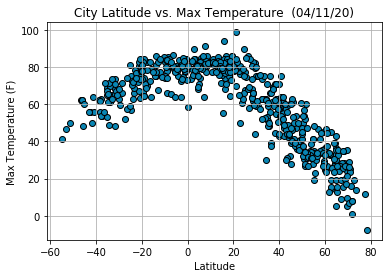

<Figure size 432x288 with 0 Axes>

In [9]:
fig = plt.figure()
pfile = "scplot_tpr.png"
#
plt.scatter(weather_data['Lat'], weather_data['Max Temp'], marker="o", facecolors="#0986B4", edgecolors="black")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title("City Latitude vs. Max Temperature  " + sdate)
plt.grid()
plt.savefig(plot_out_dir + pfile)
plt.show()
plt.tight_layout()

##### Note: 

This scatterplot is analyzing how the temperate might change depending on the latitude of the city. Based on the data, we can see that the closer to the equator a city is, the higher the max temperature of the city is.

#### Latitude vs. Humidity Plot

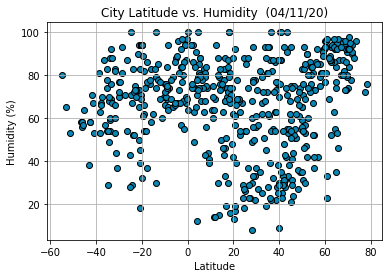

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure()
pfile = "scplot_humidity.png"
#
plt.scatter(weather_data['Lat'], weather_data['Humidity'], marker="o", facecolors="#0986B4", edgecolors="black")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title("City Latitude vs. Humidity  " + sdate)
plt.grid()
plt.savefig(plot_out_dir + pfile)
plt.show()
plt.tight_layout()

##### Note: 

This scatterplot is checking whether there is a relationship between the humidity of a city and the latitude of it. There is no distinguished pattern that emerges from the plotted data and so it seems as though the two factors are unrelated. 

#### Latitude vs. Cloudiness Plot

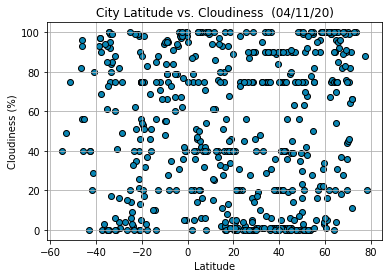

<Figure size 432x288 with 0 Axes>

In [11]:
fig = plt.figure()
pfile = "scplot_cloud.png"
#
plt.scatter(weather_data['Lat'], weather_data['Cloudiness'], marker="o", facecolors="#0986B4", edgecolors="black")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title("City Latitude vs. Cloudiness  " + sdate)
plt.grid()
plt.savefig(plot_out_dir + pfile)
plt.show()
plt.tight_layout()


##### Note: 

This scatterplot is comparing the cloudiness of a city to its latitude. Although we can see a somewhat flat lined pattern in the plot, these two factors have no correlation because this horizontal pattern indicates that the input (latitude) values are irrelevant to the output (cloudiness) values.

#### Latitude vs. Wind Speed Plot

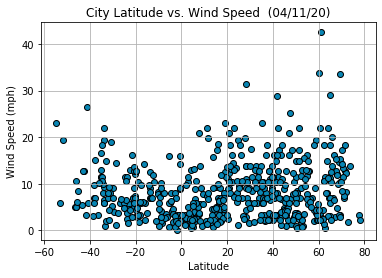

<Figure size 432x288 with 0 Axes>

In [12]:
fig = plt.figure()
pfile = "scplot_wind.png"
#
plt.scatter(weather_data['Lat'], weather_data['Wind Speed'], marker="o", facecolors="#0986B4", edgecolors="black")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title("City Latitude vs. Wind Speed  " + sdate)
plt.grid()
plt.savefig(plot_out_dir + pfile)
plt.show()
plt.tight_layout()


##### Note: 

This scatterplot is determining the relationship between a city’s latitude and its wind speed but we can observe there is no real correlation between the two. 

## Linear Regression

In [13]:
# Create Northern and Southern Hemisphere DataFrames
northern_data = weather_data.loc[weather_data["Lat"] >= 0]
northern_data.head()
# print(f"Records count in Northern Hemisphere : {len(northern_data)}")
southern_data = weather_data.loc[weather_data["Lat"] < 0]
# print(f"Records count in Southern Hemisphere : {len(southern_data)}")
southern_data.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
3,pisco,0,PE,1586645237,30,-13.7,-76.22,75,6.93
7,touros,20,BR,1586645523,88,-5.2,-35.46,80.6,5.82
8,belmonte,40,BR,1586645523,83,-15.86,-38.88,78.8,5.82
10,port elizabeth,92,ZA,1586645286,59,-33.92,25.57,64.4,5.82
12,new norfolk,40,AU,1586645238,58,-42.78,147.06,55.99,12.75


The r-squared is: 0.819482120019837


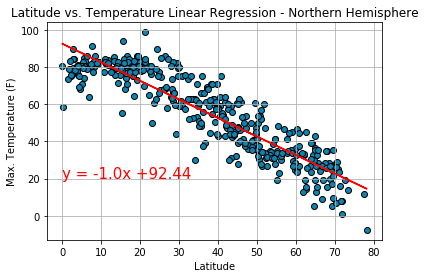

The r-squared is: 0.5699104507228068


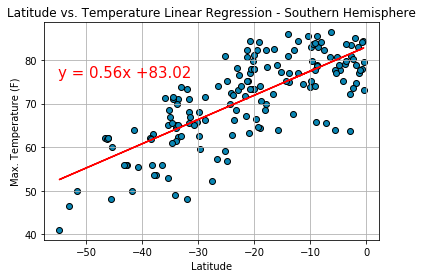

The r-squared is: 0.041311398524647505


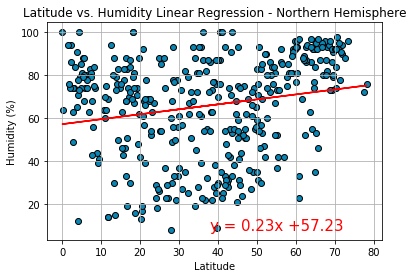

The r-squared is: 0.09311950154941326


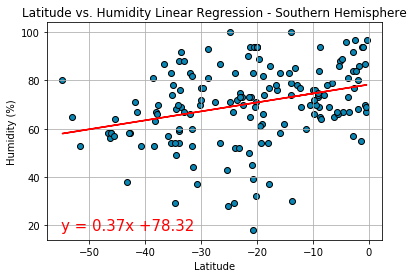

The r-squared is: 0.02453435810282304


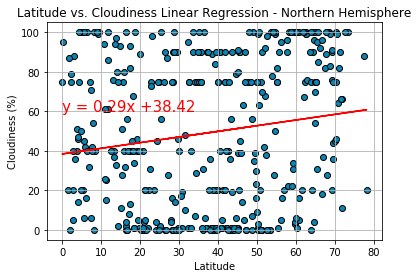

The r-squared is: 0.01715773951705034


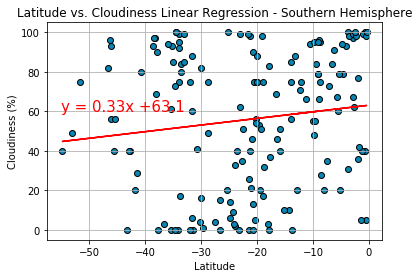

The r-squared is: 0.03172571350239082


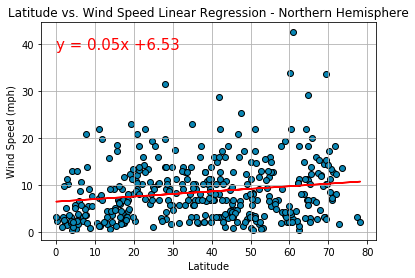

The r-squared is: 0.11873624676525608


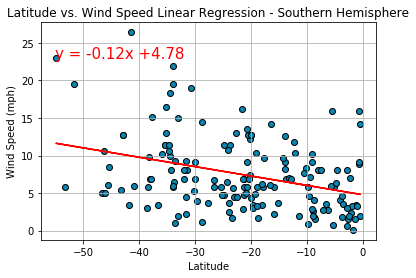

In [14]:
# OPTIONAL: Create a function to create Linear Regression plots
nfunc_data = northern_data[["Max Temp","Humidity","Cloudiness","Wind Speed","Lat"]]
sfunc_data = southern_data[["Max Temp","Humidity","Cloudiness","Wind Speed","Lat"]]
#
def cre_linear_reg_plots(x_values, y_values, vcol, suf_title):
    xmin = round(x_values.min(),0)
    xmax = round(x_values.max(),0)
    ymin = round(y_values.min(),0)
    ymax = round(y_values.max(),0)
    labels = {"Max Temp":["Max. Temperature (F)","Latitude vs. Temperature Linear Regression - ","flrscplot_tpr_",xmin,ymin+28],
              "Humidity":["Humidity (%)","Latitude vs. Humidity Linear Regression - ","flrscplot_humidity_",xmin,ymin],
              "Cloudiness":["Cloudiness (%)","Latitude vs. Cloudiness Linear Regression - ","flrscplot_cloud_",xmin,ymax-40],
              "Wind Speed":["Wind Speed (mph)","Latitude vs. Wind Speed Linear Regression - ","flrscplot_cloud_",xmin,ymax-3]
            }
    func_out_dir = "../output_data/"
    x = labels[vcol][3]
    y = labels[vcol][4]
    if suf_title == 'Northern Hemisphere':
        suf_pfile = 'nh.png'
        if vcol == "Max Temp":
            y = (ymin+28)
        if vcol == "Humidity":
            x = xmax-40
    else:
        suf_pfile = 'sh.png'
        if vcol == "Max Temp":
            y = (ymax-10)

    vtitle = labels[vcol][1]+suf_title
    vylabel = labels[vcol][0]
    vfile = labels[vcol][2] + suf_pfile
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    line_eq
    fig = plt.figure()
    plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
    plt.plot(x_values,regress_values,"r-")
    plt.title(vtitle)
    plt.xlabel('Latitude')
    plt.ylabel(vylabel)
    plt.annotate(line_eq,(x,y),fontsize=15,color="red")
    plt.grid()
    print(f"The r-squared is: {rvalue**2}")
    plt.savefig(func_out_dir + vfile)
    plt.show()

for col in nfunc_data.columns:
    if col == "Lat":
        break
    # Calling to plot Northern Hemisphere...
    cre_linear_reg_plots(nfunc_data["Lat"], nfunc_data[col], col, "Northern Hemisphere")
    # Calling to plot Southern Hemisphere...
    cre_linear_reg_plots(sfunc_data["Lat"], sfunc_data[col], col, "Southern Hemisphere")


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.819482120019837


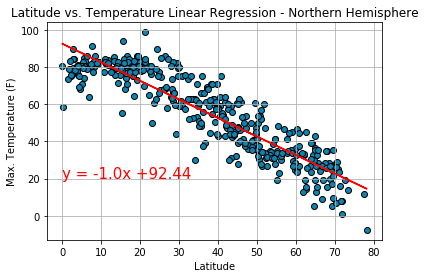

In [15]:
x_values = northern_data['Lat']
y_values = northern_data['Max Temp']
x = round(x_values.min(),0)
y = (y_values.min()+28)
pfile = "lrscplot_temp_nh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Temperature Linear Regression - Northern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Max. Temperature (F)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.5699104507228068


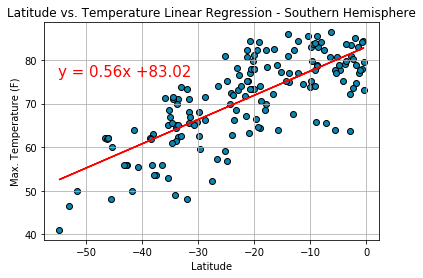

In [16]:
x_values = southern_data['Lat']
y_values = southern_data['Max Temp']
x = round(x_values.min(),0)
y = (y_values.max()-10)
pfile = "lrscplot_temp_sh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Temperature Linear Regression - Southern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Max. Temperature (F)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

##### Note:

Both scatterplots confirm that the max temperature of the city decreases as the city’s latitude is further away from the equator but the Northern Hemisphere has a much stronger relationship between the two factors (r-squared value) than the Southern Hemisphere (r-squared value).

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.041311398524647505


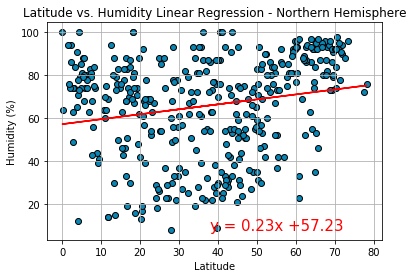

In [17]:
x_values = northern_data['Lat']
y_values = northern_data['Humidity']
x = round(x_values.max()-40,0)
y = (y_values.min())
pfile = "lrscplot_humidity_nh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Humidity Linear Regression - Northern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.09311950154941326


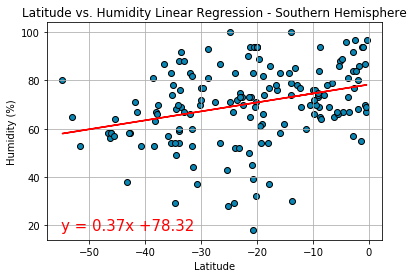

In [18]:
x_values = southern_data['Lat']
y_values = southern_data['Humidity']
x = round(x_values.min(),0)
y = (y_values.min())
pfile = "lrscplot_humidity_sh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Humidity Linear Regression - Southern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

##### Note:

This chart indicate that there is a very weak correlation between the latitude and humidity of a city for both Hemispheres. 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.02453435810282304


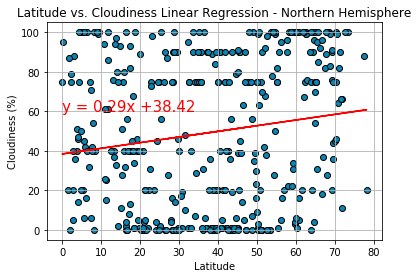

In [19]:
x_values = northern_data['Lat']
y_values = northern_data['Cloudiness']
x = round(x_values.min(),0)
y = (y_values.max()-40)
pfile = "lrscplot_cloud_nh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Cloudiness Linear Regression - Northern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.01715773951705034


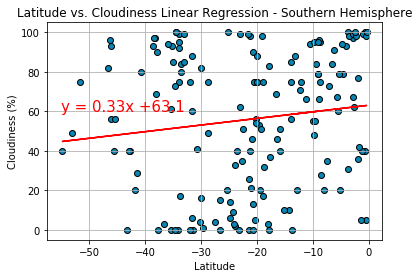

In [20]:
x_values = southern_data['Lat']
y_values = southern_data['Cloudiness']
x = round(x_values.min(),0)
y = (y_values.max()-40)
pfile = "lrscplot_cloud_sh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Cloudiness Linear Regression - Southern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

##### Note:

The Northern Hemisphere’s numbers indicate that there is no relationship between the latitude of a city and its cloudiness. The Southern Hemisphere, on the other hand, has a high positive regression coefficient but a low r-squared value. This shows us that while there seems to be a fairly strong correlation suggesting that cities closer to the equator on the Southern Hemisphere have a higher percentage of cloudiness, there is a high variation in the results. A low r-squared value says that the latitude of a city is not a very strong predictor of the cloudiness of the city. 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.03172571350239082


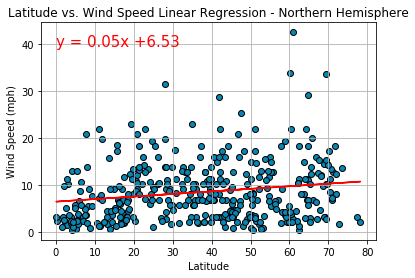

In [21]:
x_values = northern_data['Lat']
y_values = northern_data['Wind Speed']
x = round(x_values.min(),0)
y = (y_values.max()-3)
pfile = "lrscplot_wind_nh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Wind Speed Linear Regression - Northern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.11873624676525608


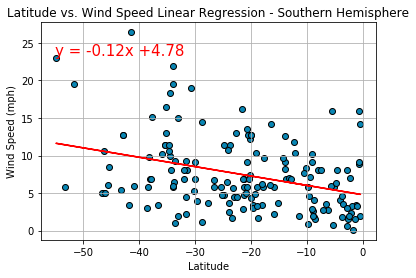

In [22]:
x_values = southern_data['Lat']
y_values = southern_data['Wind Speed']
x = round(x_values.min(),0)
y = (y_values.max()-3)
pfile = "lrscplot_wind_sh.png"
#
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
line_eq
#
fig = plt.figure()
plt.scatter(x_values,y_values, marker="o", facecolors="#0986B4", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.title("Latitude vs. Wind Speed Linear Regression - Southern Hemisphere")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(line_eq,(x,y),fontsize=15,color="red")
plt.grid()
print(f"The r-squared is: {rvalue**2}")
plt.savefig(plot_out_dir + pfile)
plt.show()

##### Note:

The linear regression coefficient and r-squared values for both hemispheres are under 0.01 and so we can determine that there is absolutely no relationship between the latitude and windiness of a city.

#### Observable Trends:

* The latitude of a city is very strongly related to the maximum temperature of the city. The closer to the equator a city is, the higher the maximum temperature is, especially for the Northern Hemisphere.

* The Southern Hemisphere’s linear regression coefficient shows that there may be a strong correlation between the latitude and cloudiness of a city (the closer a city is to the equator, the higher the cloudiness percentage) but its low r-squared value indicates that the latitude isn’t a strong factor in predicting the cloudiness of a city.

* Furthermore, from the scatterplots and linear regression analysis, we can determine that the latitude of a city is not predictive of the humidity or wind speed of that city. 